In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.feature_selection import RFECV

In [2]:
# Load dataset
data=pd.read_csv("C:\\Users\\mo69fon\\Small_Molecules_SP\\SM+PD2.csv")
data

,Name,Solubility parameter,number of repeating units,Molecular weight,Connectivity index 0X,Connectivity index 1X,Connectivity index 0Xv,Connectivity index 1Xv,Quadrupole moment,Atomization energy (kJ/mol),...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,"2,2,3,3-tetramethylbutane",14.58,1,114.000,6.414214,3.457107,6.414214,3.457107,-41.98,10230.26,...,4.390033,14.062500,1.757812,0.000000,0.000000,0.0,58,9,4.844,38
1,"2,2,3-trimethylbutane",14.07,1,100.000,5.491564,3.127827,5.491564,3.127827,-36.86,9031.25,...,4.353270,12.293055,1.756151,0.000000,0.000000,0.0,42,6,4.238,30
2,"2,2-dimethyl-3-hexanol",19.31,1,130.000,6.905777,4.127827,6.352991,3.808676,-45.38,10653.67,...,4.819843,16.266070,1.807341,2.430904,2.430904,0.0,92,9,2.361,38
3,"2,2-dimethyl-3-pentanol",19.57,1,116.000,6.198671,3.627827,5.645884,3.308676,-40.05,9437.67,...,4.838338,14.275065,1.784383,2.396386,2.396386,0.0,63,8,1.792,34
4,"2,2-dimethylbutane",13.75,1,86.000,4.621320,2.707107,4.621320,2.707107,-31.76,7826.93,...,4.305478,10.465990,1.744332,0.000000,0.000000,0.0,28,3,3.730,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2-methyl-3-pentanol,20.70,1,102.170,5.276021,3.304530,4.723234,2.985379,-35.58,8227.16,...,4.862117,12.505243,1.786463,2.394392,2.394392,0.0,46,6,1.397,26
311,3-methyl-2-pentanol,21.11,1,102.170,5.276021,3.304530,4.723234,2.985379,-34.75,8224.03,...,4.862117,12.505243,1.786463,2.348368,2.348368,0.0,46,6,1.608,26
312,4-methyl-2-pentanol,21.37,1,102.170,5.276021,3.287694,4.723234,2.968542,-36.18,8228.90,...,4.862117,12.509162,1.787023,2.353722,2.353722,0.0,48,4,1.819,26
313,"3,3-dimethyl-2-butanol",20.21,1,102.170,5.491564,3.127827,4.938777,2.808676,-34.78,8224.63,...,4.862117,12.293055,1.756151,2.327350,2.327350,0.0,42,6,1.434,30


In [3]:
# Before splitting, store the indices
original_indices = data.index

In [4]:
# Remove descriptors with all 0 columns
newdata = data.loc[:, (data != 0).any(axis=0)]
print('----- after removing rows with only 0 -----')
print('new data shape:', newdata.shape)

----- after removing rows with only 0 -----
new data shape: (315, 1083)


In [5]:
# Define target values and variables
cols = list(newdata.columns)
x = newdata.iloc[:,2:]
y = newdata.iloc[:,1] 
paras = cols[2:]

In [6]:
#Convert it to a DataFrame
X = pd.DataFrame(x)

In [7]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Get the correct indices from the split data
train_indices = X_train.index
test_indices = X_test.index

In [9]:
# Fill NaN values with column means
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [10]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Apply RFECV to reduce dimensionality with Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rfecv = RFECV(estimator=rf, step=5, cv=5, scoring='r2', n_jobs=-1)
X_train_rfecv = rfecv.fit_transform(X_train, y_train)
X_test_rfecv = rfecv.transform(X_test)

In [12]:
# Generate ranking for features
rfecv_ranking = pd.DataFrame({'Descriptors': paras, 'Ranking': rfecv.ranking_})
print(rfecv_ranking.sort_values('Ranking'))

                   Descriptors  Ranking
0    number of repeating units        1
338                     GATS1e        1
88                      AATS1v        1
362                     GATS1s        1
402                    SM1_Dzv        1
..                         ...      ...
688                      naaCH      204
778                     mintsC      204
692                      naasC      204
953                    MDEC-14      204
682                     nHAvin      204

[1081 rows x 2 columns]


In [13]:
# Generate mean test scores for different numbers of descriptors:

rfecv.ranking = pd.DataFrame({'Descriptors': paras,
                              'Ranking_': rfecv.ranking_})
rfecv.ranking = rfecv.ranking[rfecv.ranking.iloc[:, 1] == 1]
#rfecv.ranking.to_excel('rfecv_lasso.ranking.xlsx', index=False)

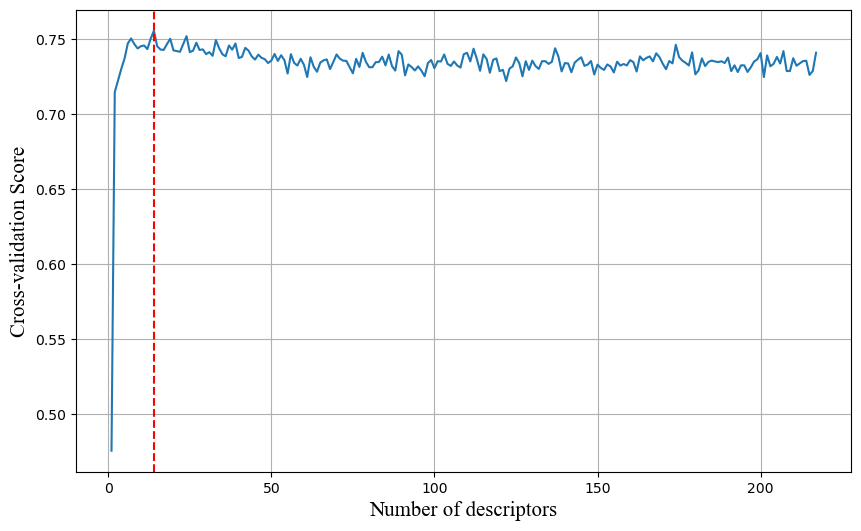

Maximum CV score: 0.7553344660639906 with 14 descriptors


In [14]:
# Generate rankings of the descriptors based on their importance:
sorted_Number_of_descriptors = range(1, len(rfecv.cv_results_["mean_test_score"]) + 1)
mean_test_score = pd.DataFrame({
    'Number of descriptors': sorted_Number_of_descriptors,
    'Mean_test_score': rfecv.cv_results_["mean_test_score"]
})

# Plot the cross-validation score vs. the number of descriptors:
plt.figure(figsize=(10, 6))
plt.plot(sorted_Number_of_descriptors, rfecv.cv_results_["mean_test_score"])
plt.xlabel('Number of descriptors', fontdict={'size': 15, 'family': 'Times New Roman'})
plt.ylabel('Cross-validation Score', fontdict={'size': 15, 'family': 'Times New Roman'})
#plt.title('RFECV for RF', fontdict={'size': 20, 'family': 'Times New Roman'})
plt.grid(True)

# Find the maximum cross-validation score and its corresponding number of descriptors
max_score_index = rfecv.cv_results_["mean_test_score"].argmax()
max_score = rfecv.cv_results_["mean_test_score"][max_score_index]

plt.axvline(x=sorted_Number_of_descriptors[max_score_index], color='r', linestyle='--')
# Save the plot
#plt.savefig('Final_RFECV_RF.png', bbox_inches='tight', dpi=800)
plt.show()

print(f"Maximum CV score: {max_score} with {sorted_Number_of_descriptors[max_score_index]} descriptors")

In [15]:
max_score_index

13

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF, WhiteKernel
# Define GPR kernel
kernel_matern = Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)

In [17]:
gpr_model = GaussianProcessRegressor(kernel=kernel_matern,alpha=1e-2, normalize_y=True, random_state=42)

In [18]:
# Fit the model
gpr_model.fit(X_train_rfecv, y_train)

,kernel,Matern(length...noise_level=1)
,alpha,0.01
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,"Matern(length_scale=1, nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__length_scale,1.0


In [19]:
print("Optimized kernel:", gpr_model.kernel_)

Optimized kernel: Matern(length_scale=11.4, nu=1.5) + WhiteKernel(noise_level=0.00977)


In [20]:
num_runs=5
run_times_seconds=[]
for run in range(num_runs):
    start_time = time.time()
    gpr_model.fit(X_train_rfecv, y_train)
    end_time = time.time()
    elapsed_time_sec = end_time - start_time
    run_times_seconds.append(elapsed_time_sec)
    elapsed_time_min = elapsed_time_sec / 60
    print(f"Run {run + 1}: {elapsed_time_sec:.2f} seconds ({elapsed_time_min:.2f} minutes)")
    
# Compute average and std dev
avg_sec = np.mean(run_times_seconds)
std_sec = np.std(run_times_seconds)
avg_min = avg_sec / 60
std_min = std_sec / 60

# Final output
print(f"\nAverage training time: {avg_sec:.2f} seconds ({avg_min:.2f} minutes)")
print(f"Standard deviation: {std_sec:.2f} seconds ({std_min:.2f} minutes)")

Run 1: 0.09 seconds (0.00 minutes)
Run 2: 0.12 seconds (0.00 minutes)
Run 3: 0.11 seconds (0.00 minutes)
Run 4: 0.12 seconds (0.00 minutes)
Run 5: 0.10 seconds (0.00 minutes)

Average training time: 0.11 seconds (0.00 minutes)
Standard deviation: 0.01 seconds (0.00 minutes)


In [21]:
# Make predictions
y_train_pred = gpr_model.predict(X_train_rfecv)
y_test_pred = gpr_model.predict(X_test_rfecv)

In [22]:
# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [23]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [24]:
train_r2

0.9907470052649537

In [25]:
test_r2

0.9363054496743064

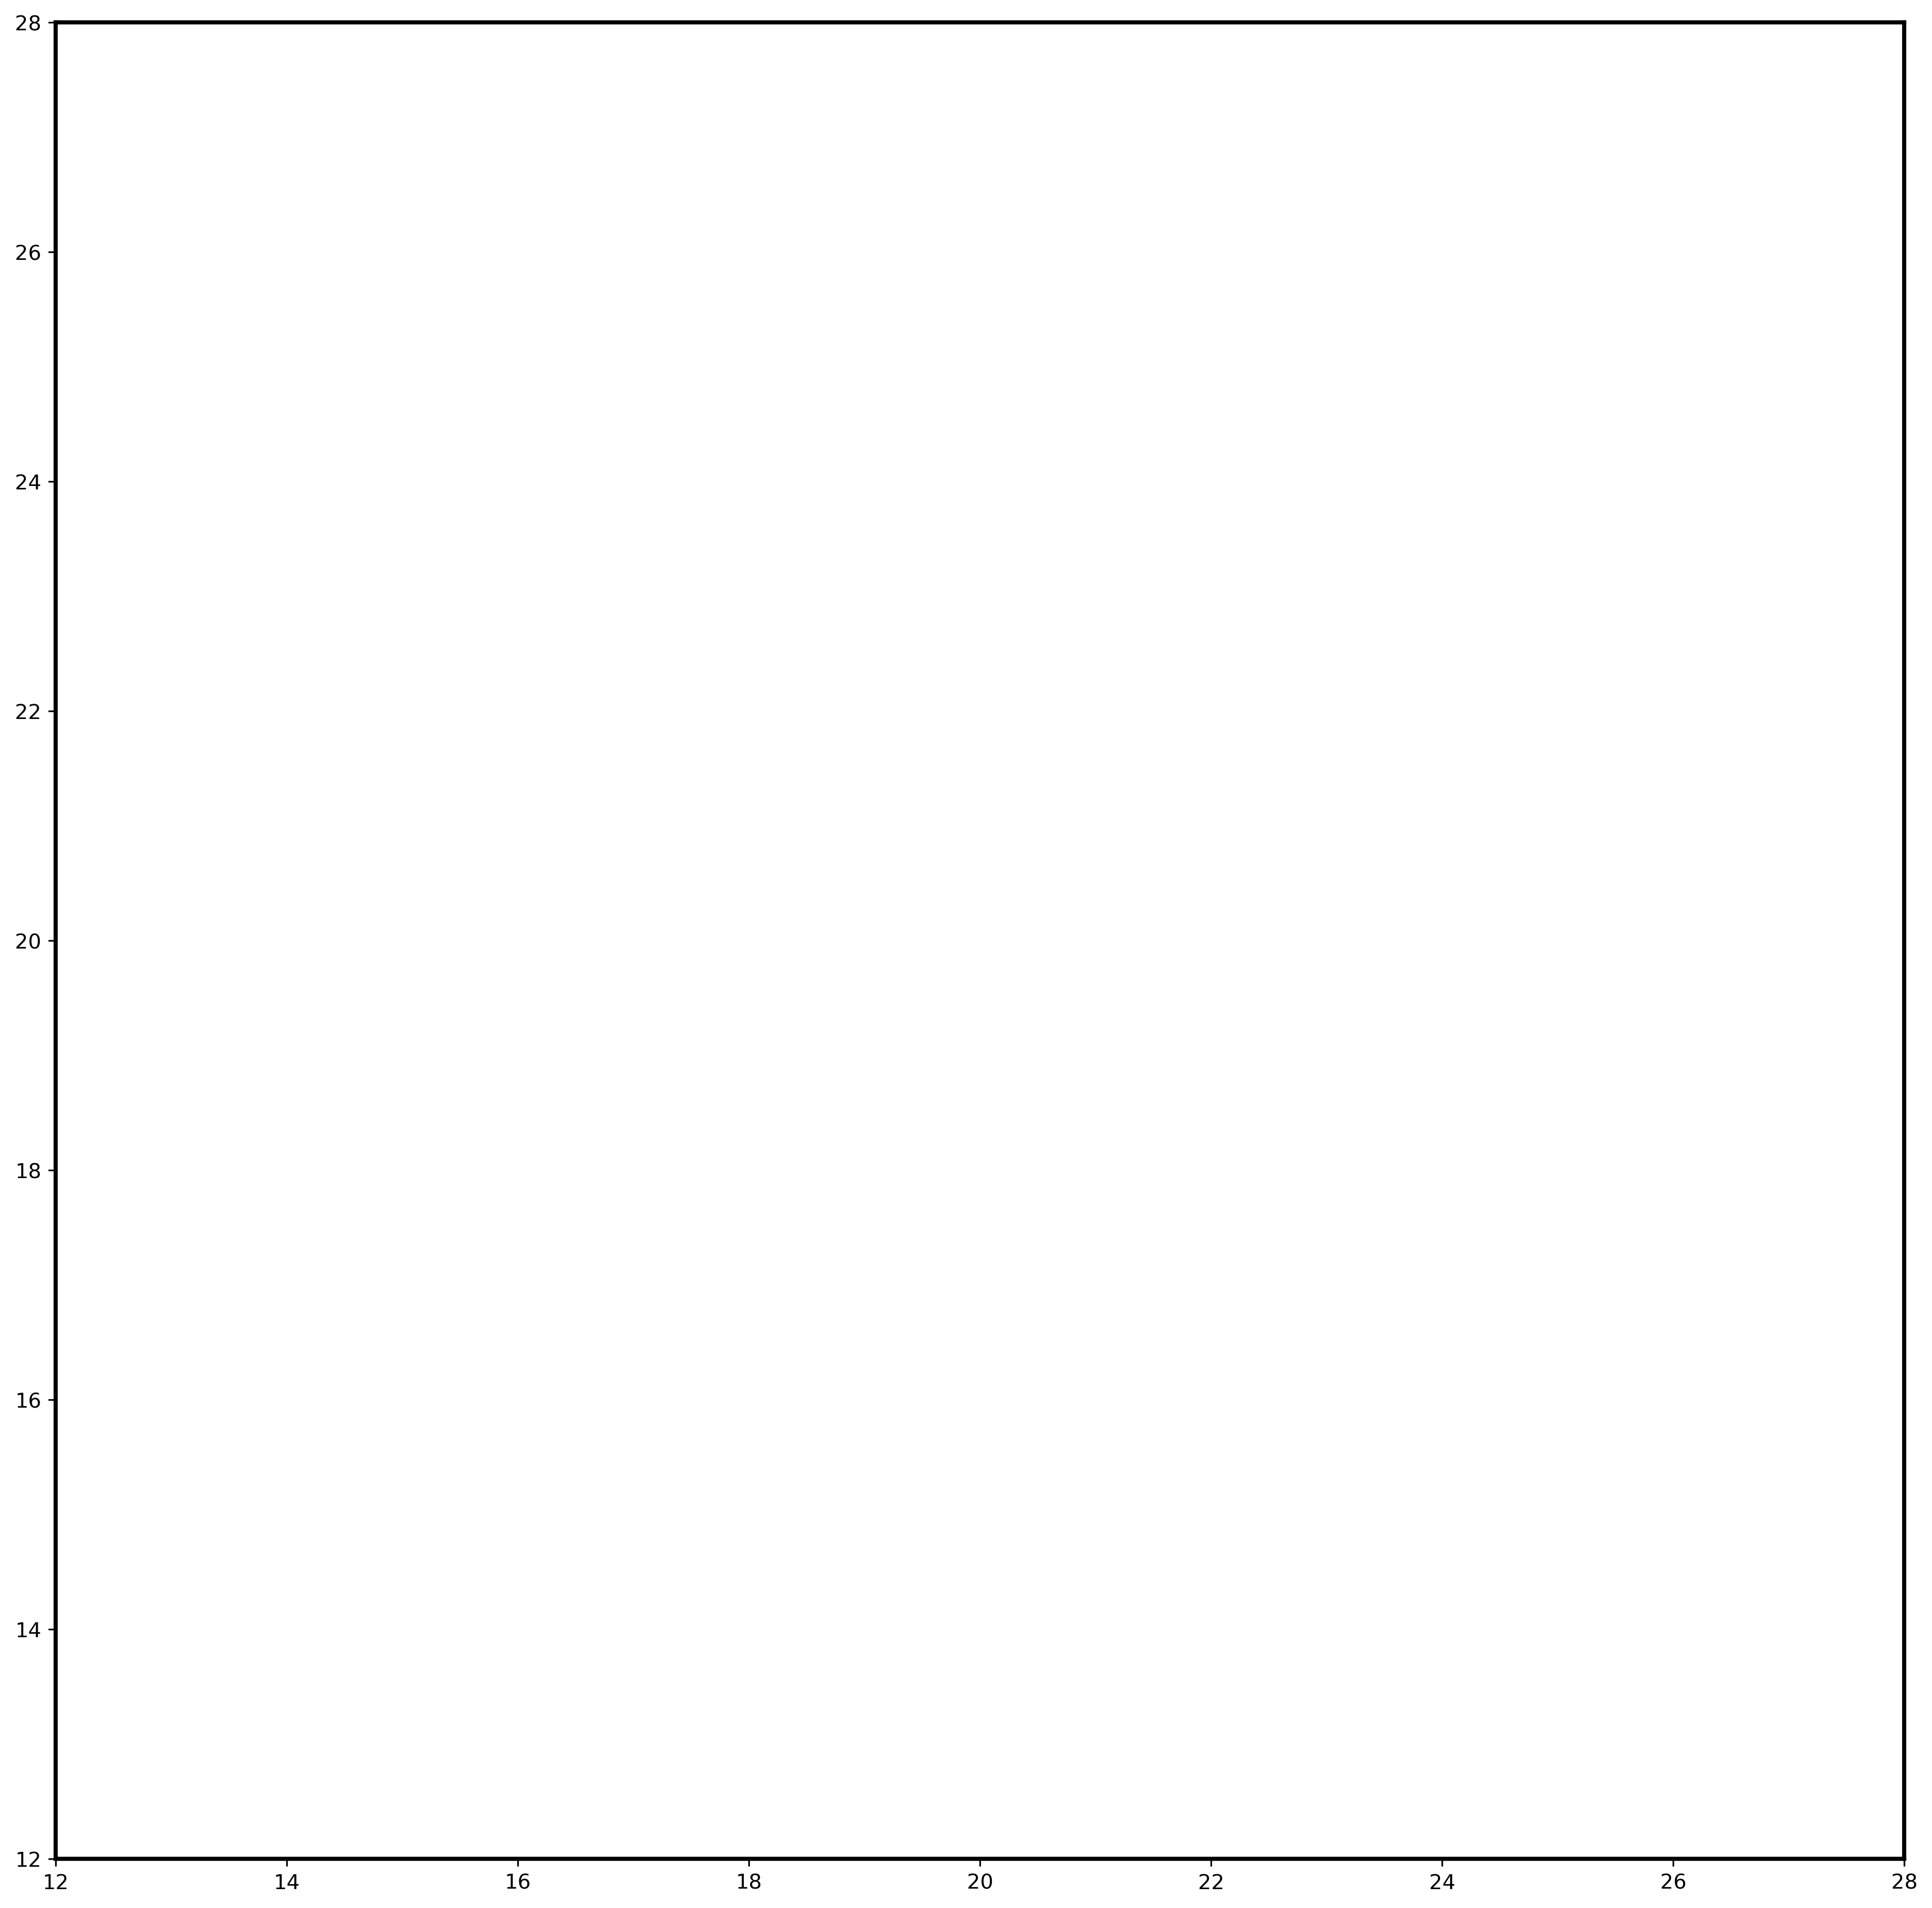

In [26]:
# Plot the predicted values versus the true values for the training and test sets
f, ax = plt.subplots(figsize=(16, 16),dpi=300)
plt.xlim((12, 28))
plt.ylim((12, 28))
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

In [31]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

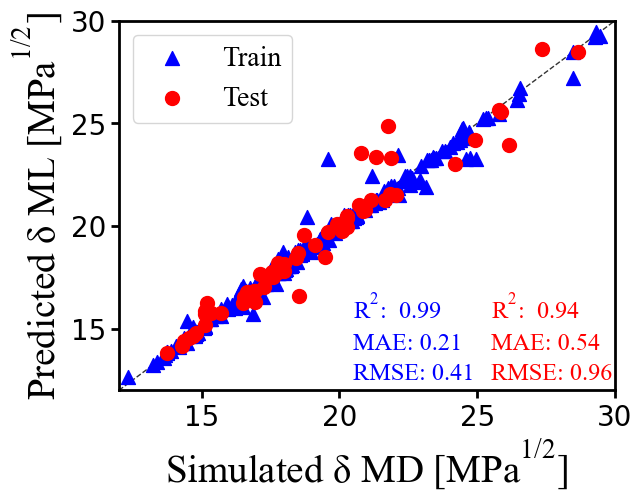

In [27]:
import matplotlib.pyplot as plt
orange_accent2 = (255/255, 192/255, 0/255)
plt.plot([12, 30], [12, 30], ls="--", c=".2", linewidth=1, zorder=1)
plt.scatter(y_train, y_train_pred, c='blue', marker='^', s=100, label='Train', zorder=2)
plt.scatter(y_test, y_test_pred, c='red', marker='o', s=100, label='Test', zorder=2)
plt.xlim(12, 30)
#plt.xticks([])
plt.ylim(12, 30)

# Set font properties
font_properties = {'family': 'Times New Roman', 'size': 28}

# Apply black border and customize ticks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(2)

# Increase tick size and label size
plt.tick_params(axis='both', which='major', labelsize=20, width=2, length=6)


plt.xlabel('Simulated δ MD [$\mathregular {MPa^{1/2}}$]',fontsize=28,family= 'Times New Roman')
plt.ylabel('Predicted δ ML [$\mathregular {MPa^{1/2}}$]',fontsize=28,family= 'Times New Roman')

# Legend
plt.legend(loc='upper left', prop={'size': 20, 'family': 'Times New Roman'})

plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(test_r2),
        (22, 14), xytext=(25.5, 15.5),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("MAE:{:5.2f}".format(test_mae),
        (22, 14), xytext=(25.5, 14),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("RMSE:{:5.2f}".format(test_rmse),
        (22, 14), xytext=(25.5, 12.5),
        fontsize=17.5,family= 'Times New Roman',c='red')
plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(train_r2),
        (22, 14), xytext=(20.5, 15.5),
        fontsize=17.5,family= 'Times New Roman',c='blue')
plt.annotate("MAE:{:5.2f}".format(train_mae),
        (22, 14), xytext=(20.5, 14),
        fontsize=17.5,family= 'Times New Roman',c='blue')
plt.annotate("RMSE:{:5.2f}".format(train_rmse),
        (22, 14), xytext=(20.5, 12.5),
        fontsize=17.5,family= 'Times New Roman',c='blue')
#plt.title('PCA_NN',x=0.5,y=1.01,fontsize=25,family= 'Times New Roman')
#plt.savefig('GPR_RFECV_paper.png', bbox_inches='tight', dpi=800)
plt.show()

In [29]:
# output scores and best parameters
print("Train R2 Score:", train_r2)
print("Test R2 Score:", test_r2)
print("Train MAE Score:", train_mae)
print("Test MAE Score:", test_mae)
print("Train RMSE Score:", train_rmse)
print("Test RMSE Score:", test_rmse)

Train R2 Score: 0.9907470052649537
Test R2 Score: 0.9363054496743064
Train MAE Score: 0.2120853553961735
Test MAE Score: 0.5355524424583716
Train RMSE Score: 0.4087279212108526
Test RMSE Score: 0.9563177910730083
